# Exploration and Comparison of Transformers for Image Classification

## Zero-Shot Transfer using CLIP


Zero-shot image classification is a task that involves classifying images into different categories using a model that was not explicitly trained on data containing labeled examples from those specific categories.

### CLIP (Contrastive Language-Image Pre-Training)

The CLIP model was proposed in *Learning Transferable Visual Models From Natural Language Supervision by Alec Radford, Jong Wook Kim, Chris Hallacy, Aditya Ramesh, Gabriel Goh, Sandhini Agarwal, Girish Sastry, Amanda Askell, Pamela Mishkin, Jack Clark, Gretchen Krueger, Ilya Sutskever*. 

CLIP (Contrastive Language-Image Pre-Training) is a neural network trained on a variety of (image, text) pairs. It can be instructed in natural language to predict the most relevant text snippet, given an image, without directly optimizing for the task, similarly to the zero-shot capabilities of GPT-2 and 3.

https://arxiv.org/abs/2103.0002030

### Prerequisites

Load necessary packages.

In [15]:
import os
os.chdir('..')

import torch

import pandas as pd

from datasets import load_dataset

from src.dataset_builder import ImageDataset
from src.models import CLIP
from src.train import *

from utils.config import Config
from utils.train_utils import *
from utils.models_utils import *
from utils.visualization_utils import *
from utils.data_utils import *

Check if there is GPU available.

In [3]:
get_gpu_info()

GPU 0: NVIDIA A100 80GB PCIe MIG 2g.20gb
VRAM: 19.50 GB


Set manual seed for reproducibility.

In [4]:
id = 10
torch.manual_seed(10)

### Model

Load pre-trained CLIP model.

In [5]:
model = CLIP()

Print the number of parameters.

In [6]:
get_model_params(model)

Parameters: 149.62M


Load CLIP image processor and tokenizer used for image and text pre-processing.

In [7]:
processor, tokenizer = get_clip_processor_and_tokenizer()

### Data Preprocessing

Load each dataset and clean its labels.

CLIP's processor and tokenizer is automatically applied to images and corresponding texts.

Since this is a zero-shot transfer experiment, only the test/validation split is needed.

#### RESISC45

In [8]:
resisc45 = load_dataset('timm/resisc45')
clean_labels(resisc45, name='resisc45')
resisc45 = ImageDataset(
    dataset=resisc45['test'],
    processor=processor,
    tokenizer=tokenizer,
    create_captions=True,
    prompt="{}",
)
resisc45.dataset

Dataset({
    features: ['image', 'label', 'image_id'],
    num_rows: 6300
})

#### Food-101

In [9]:
food101 = load_dataset('ethz/food101')
clean_labels(food101, name='food101')
food101 = ImageDataset(
    dataset=food101['validation'],
    processor=processor,
    tokenizer=tokenizer,
    create_captions=True,
    prompt="{}",
)
food101.dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 25250
})

#### FER2013

In [10]:
fer2013 = load_dataset('AutumnQiu/fer2013')
clean_labels(fer2013, name='fer2013')
fer2013 = ImageDataset(
    dataset=fer2013['test'],
    processor=processor,
    tokenizer=tokenizer,
    create_captions=True,
    prompt="{}",
)
fer2013.dataset

Dataset({
    features: ['label', 'image'],
    num_rows: 3589
})

#### PCam

In [11]:
pcam = load_dataset('zacharielegault/PatchCamelyon')
clean_labels(pcam, name='pcam')
pcam = ImageDataset(
    dataset=pcam['test'],
    processor=processor,
    tokenizer=tokenizer,
    create_captions=True,
    prompt="{}",
)
pcam.dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 32768
})

#### SUN397

In [12]:
sun397 = load_dataset('dpdl-benchmark/sun397')
clean_labels(sun397, name='sun397')
sun397 = ImageDataset(
    dataset=sun397['test'],
    processor=processor,
    tokenizer=tokenizer,
    create_captions=True,
    prompt="{}",
)
sun397.dataset

Resolving data files:   0%|          | 0/28 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/28 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/28 [00:00<?, ?it/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 21750
})

#### DTD

In [14]:
dtd = load_dataset('tanganke/dtd')
clean_labels(dtd, name='dtd')
dtd = ImageDataset(
    dataset=dtd['test'],
    processor=processor,
    tokenizer=tokenizer,
    create_captions=True,
    prompt="{}"
)
dtd.dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 1880
})

### Config

Create a config for experiments and print its settings.

In [15]:
config = Config()
config.get_settings()

{'device': 'cuda',
 'criterion': CrossEntropyLoss(),
 'batch_size': 8,
 'lr': 5e-05,
 'num_epochs': 5,
 'optimizer': torch.optim.adam.Adam,
 'weight_decay': 0.0001}

Create empty array to store dataset accuracies for each experiment.

In [3]:
resisc45_accs = []
food101_accs = []
fer2013_accs = []
pcam_accs = []
sun397_accs = []
dtd_accs = []

### Experiment #1 - No prompt

This experiment involes only using class label as text input.

#### RESISC45

In [17]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = evaluate_model(
    model,
    resisc45,
    config,
    zero_shot=True
)

100%|██████████| 788/788 [01:22<00:00,  9.58it/s]

Zero-shot evaluation completed: loss: 1.6377 | acc: 0.5438


In [59]:
resisc45_accs.append(resisc45_acc)

In [19]:
get_top_5_accuracies(resisc45_per_class_acc)

[('sea ice', 0.9867549668874173),
 ('golf course', 0.9836065573770492),
 ('baseball diamond', 0.943089430894309),
 ('mobile home park', 0.926829268292683),
 ('rectangular farmland', 0.9111111111111111)]

In [20]:
get_bottom_5_accuracies(resisc45_per_class_acc)

[('chaparral', 0.0),
 ('meadow', 0.0),
 ('terrace', 0.0),
 ('snowberg', 0.031446540880503145),
 ('overpass', 0.08)]

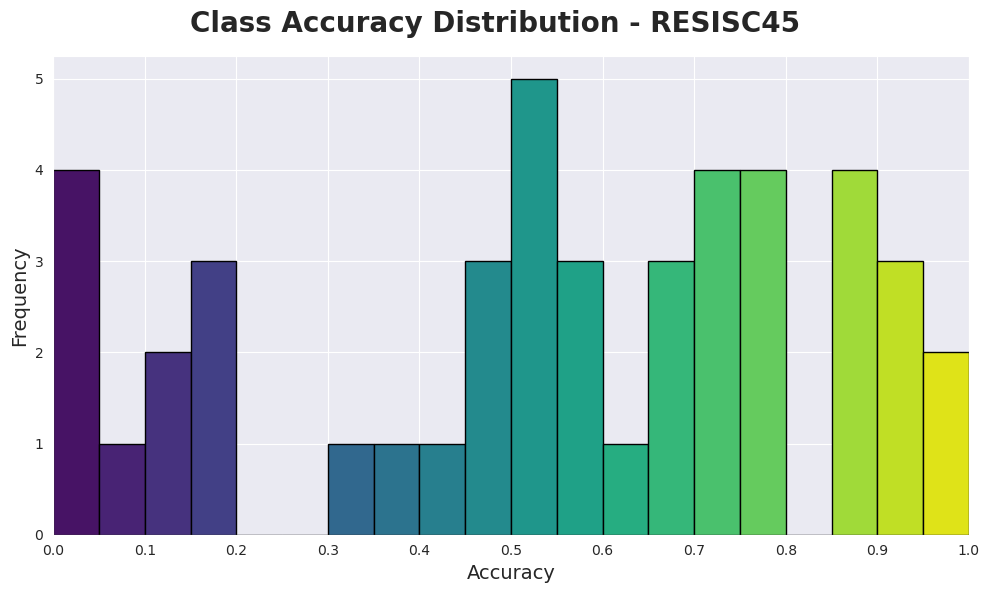

In [21]:
plot_per_class_accuracies(
    resisc45_per_class_acc,
    'RESISC45',
    num_bins=20
)

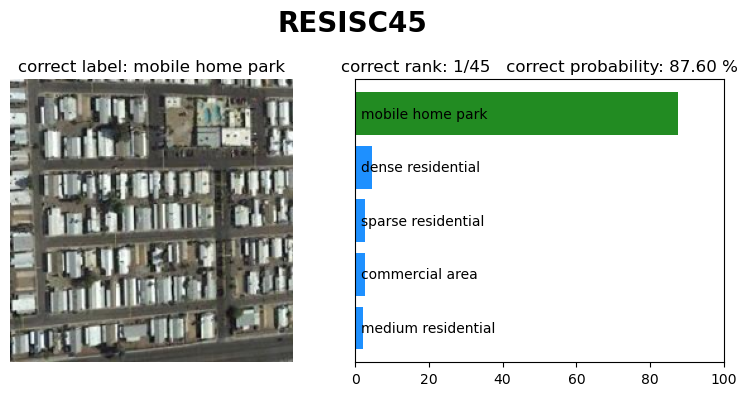

In [22]:
visualize_zero_shot_predict(
    model=model, 
    image=resisc45.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=resisc45.get_captions(),
    labels=resisc45.get_labels(),
    label=resisc45.get_label(id),
    prompt=resisc45.get_prompt(),
    title='RESISC45',
    config=config,
) 

#### Food-101

In [23]:
food101_loss, food101_acc, food101_per_class_acc = evaluate_model(
    model,
    food101,
    config,
    zero_shot=True
)

 15%|█▌        | 475/3157 [01:03<05:58,  7.49it/s]/opt/conda/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:868: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 3157/3157 [07:03<00:00,  7.46it/s]


Zero-shot evaluation completed: loss: 0.4645 | acc: 0.8668


In [60]:
food101_accs.append(food101_acc)

In [25]:
get_top_5_accuracies(food101_per_class_acc)

[('edamame', 1.0),
 ('lobster roll sandwich', 0.992),
 ('seaweed salad', 0.992),
 ('oysters', 0.984),
 ('macarons', 0.976)]

In [26]:
get_bottom_5_accuracies(food101_per_class_acc)

[('ravioli', 0.164),
 ('steak', 0.508),
 ('hamburger', 0.66),
 ('tacos', 0.664),
 ('pork chop', 0.672)]

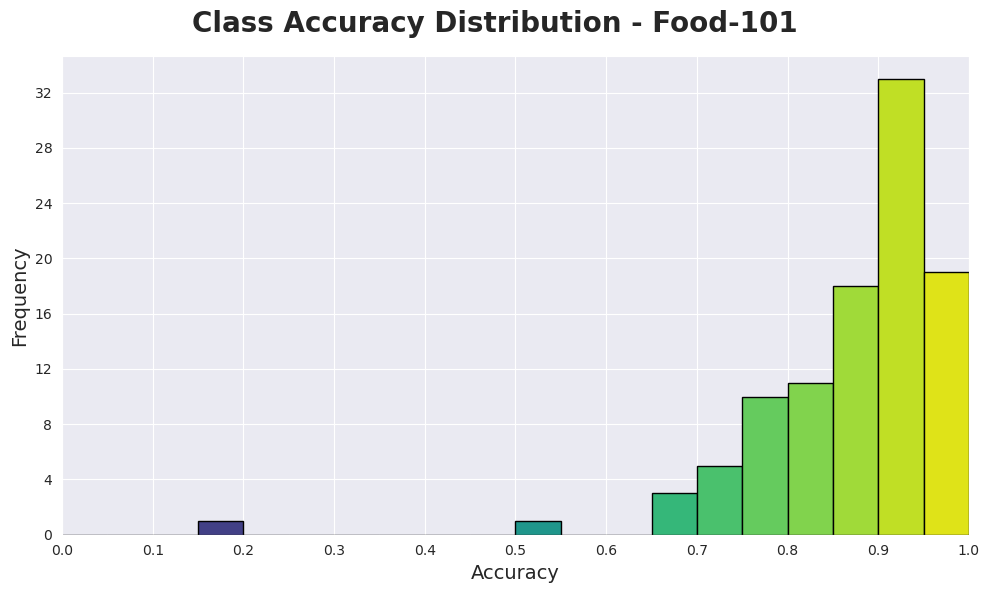

In [27]:
plot_per_class_accuracies(
    food101_per_class_acc,
    'Food-101',
    num_bins=20
)

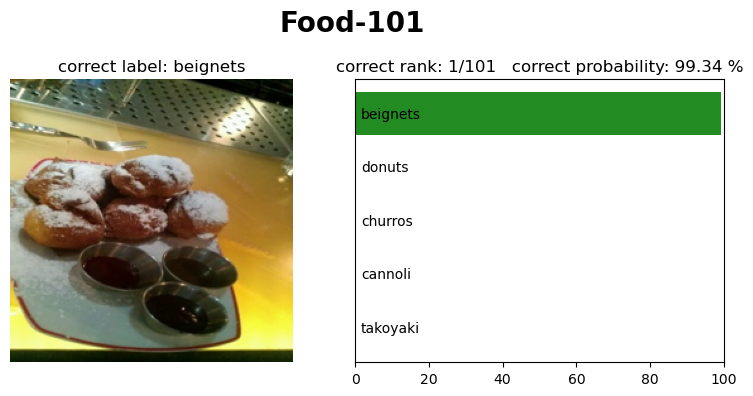

In [28]:
visualize_zero_shot_predict(
    model=model, 
    image=food101.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=food101.get_captions(),
    labels=food101.get_labels(),
    label=food101.get_label(id),
    prompt=food101.get_prompt(),
    title='Food-101',
    config=config
) 

#### FER2013

In [29]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = evaluate_model(
    model,
    fer2013,
    config,
    zero_shot=True
)

100%|██████████| 449/449 [00:41<00:00, 10.86it/s]

Zero-shot evaluation completed: loss: 1.8621 | acc: 0.4085


In [61]:
fer2013_accs.append(fer2013_acc)

In [31]:
fer2013_per_class_acc

{'angry': 0.8574338085539714,
 'disgust': 0.21818181818181817,
 'fear': 0.09659090909090909,
 'happy': 0.8714448236632537,
 'sad': 0.03198653198653199,
 'surprise': 0.46634615384615385,
 'neutral': 0.004792332268370607}

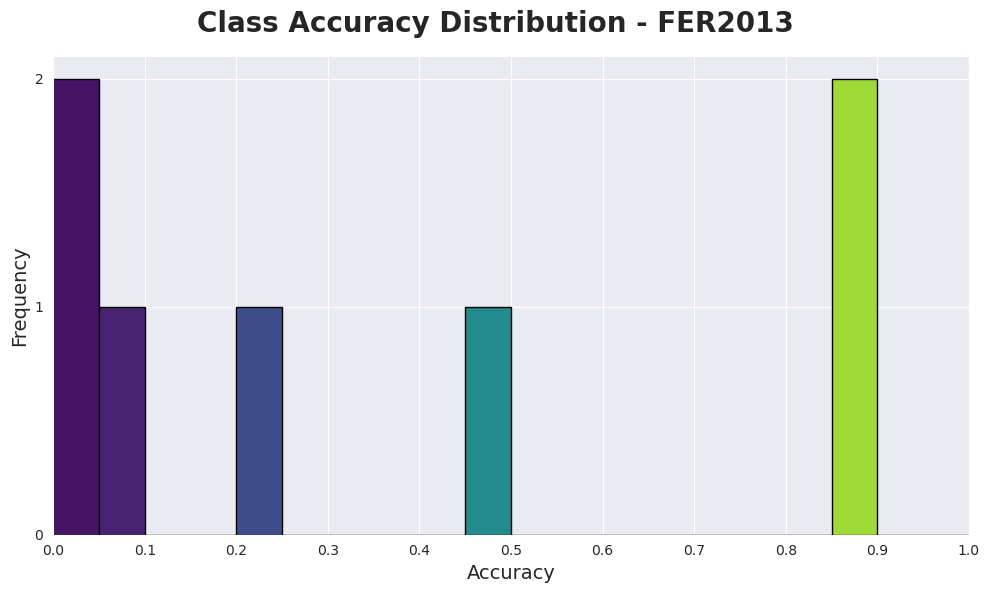

In [32]:
plot_per_class_accuracies(
    fer2013_per_class_acc,
    'FER2013',
    num_bins=20
)

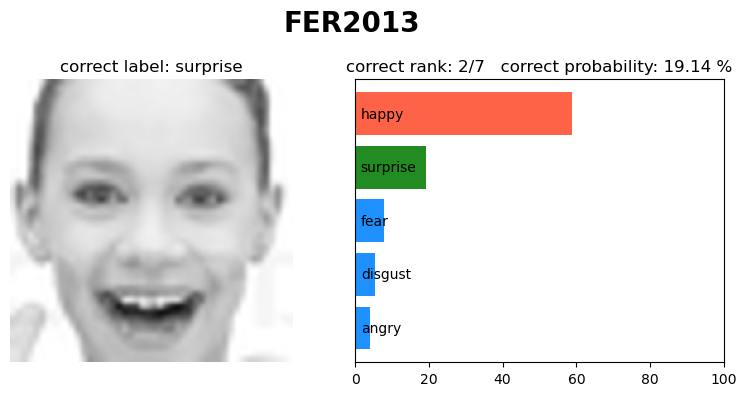

In [33]:
visualize_zero_shot_predict(
    model=model, 
    image=fer2013.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=fer2013.get_captions(),
    labels=fer2013.get_labels(),
    label=fer2013.get_label(id),
    prompt=fer2013.get_prompt(),
    title='FER2013',
    config=config
)

#### PCam

In [34]:
pcam_loss, pcam_acc, pcam_per_class_acc = evaluate_model(
    model,
    pcam,
    config,
    zero_shot=True
)

100%|██████████| 4096/4096 [06:19<00:00, 10.80it/s]

Zero-shot evaluation completed: loss: 0.6905 | acc: 0.5586


In [62]:
pcam_accs.append(pcam_acc)

In [36]:
pcam_per_class_acc

{'healthy lymph node tissue': 0.5089988408272833,
 'lymph node tumor tissue': 0.6082310557489161}

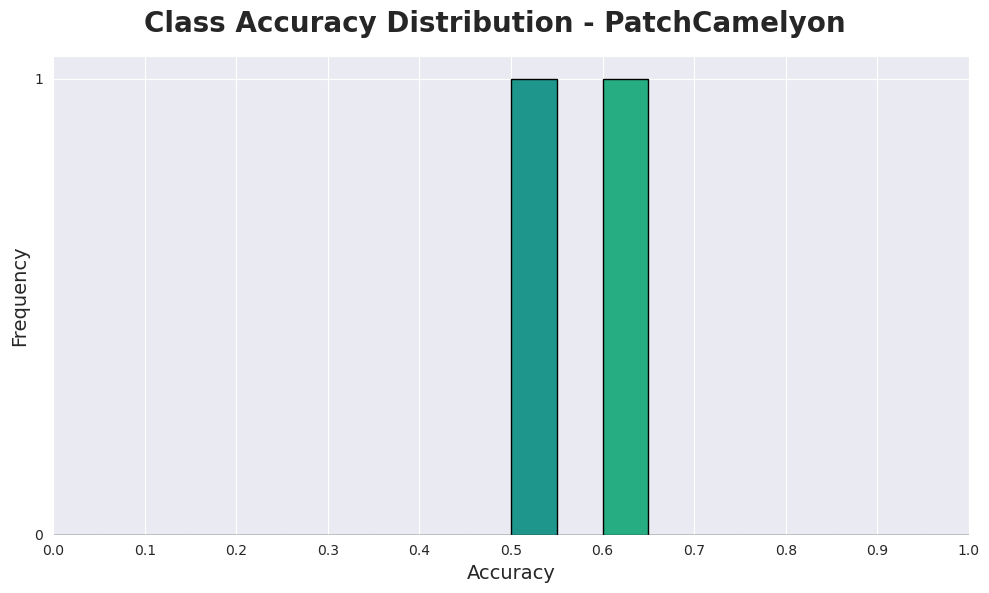

In [37]:
plot_per_class_accuracies(
    pcam_per_class_acc,
    'PatchCamelyon',
    num_bins=20
)

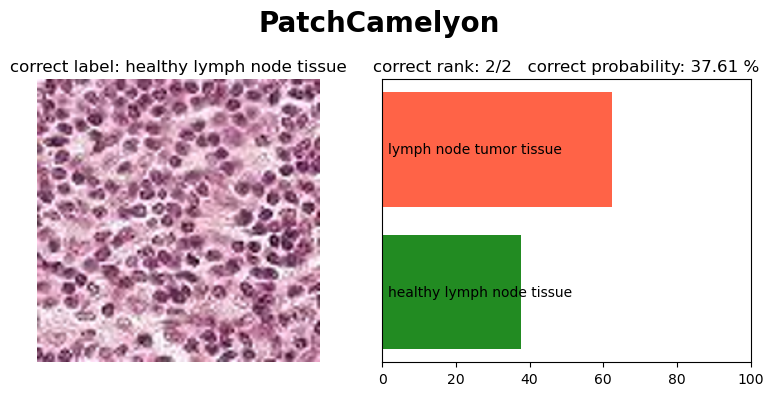

In [38]:
visualize_zero_shot_predict(
    model=model, 
    image=pcam.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=pcam.get_captions(),
    labels=pcam.get_labels(),
    label=pcam.get_label(id),
    prompt=pcam.get_prompt(),
    title='PatchCamelyon',
    config=config
)

#### SUN397

In [39]:
sun397_loss, sun397_acc, sun397_per_class_acc = evaluate_model(
    model,
    sun397,
    config,
    zero_shot=True
)

100%|██████████| 2719/2719 [08:46<00:00,  5.17it/s]


Zero-shot evaluation completed: loss: 1.5255 | acc: 0.6000


In [63]:
sun397_accs.append(sun397_acc)

In [41]:
get_top_5_accuracies(sun397_per_class_acc)

[('heliport', 1.0),
 ('kindergarden classroom', 1.0),
 ('raceway', 1.0),
 ('rock arch', 1.0),
 ('skatepark', 1.0)]

In [42]:
get_bottom_5_accuracies(sun397_per_class_acc)

[('batroom', 0.0),
 ('bazaar (outdoor)', 0.0),
 ('berth', 0.0),
 ('clean room', 0.0),
 ('conference center', 0.0)]

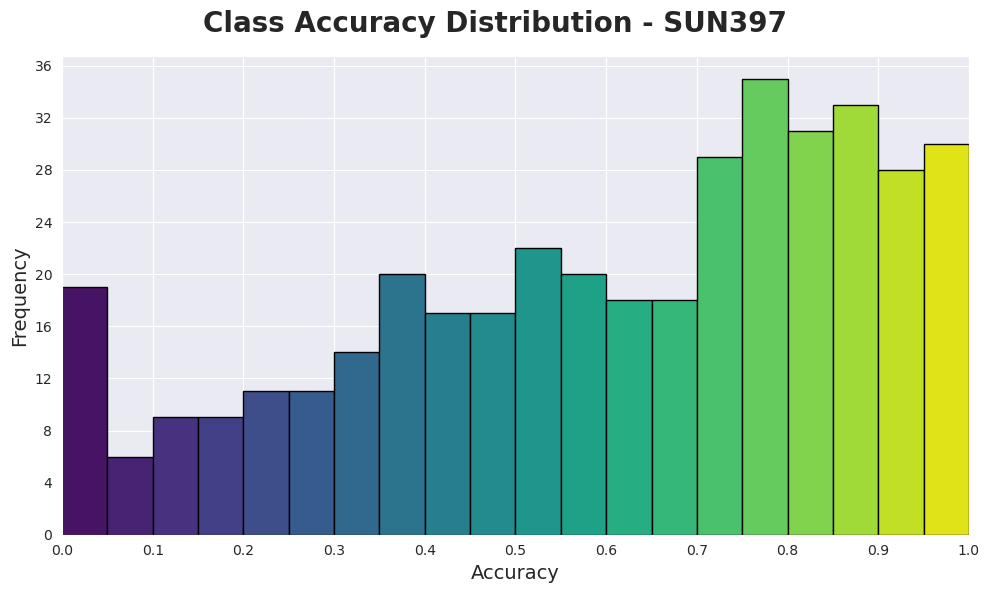

In [43]:
plot_per_class_accuracies(
    sun397_per_class_acc,
    'SUN397',
    num_bins=20
)

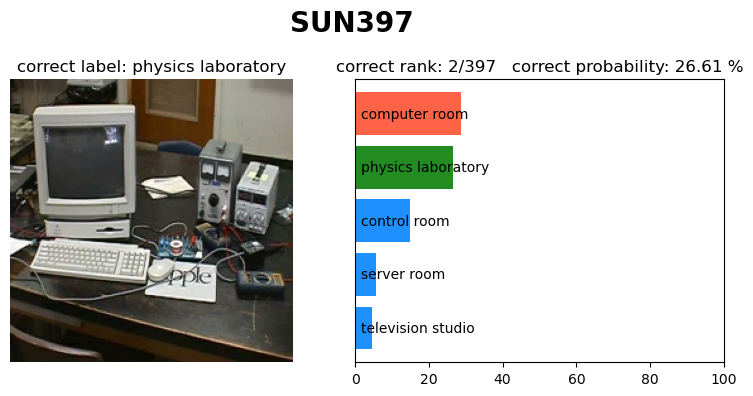

In [44]:
visualize_zero_shot_predict(
    model=model, 
    image=sun397.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=sun397.get_captions(),
    labels=sun397.get_labels(),
    label=sun397.get_label(id),
    prompt=sun397.get_prompt(),
    title='SUN397',
    config=config,
)

#### DTD

In [51]:
dtd_loss, dtd_acc, dtd_per_class_acc = evaluate_model(
    model,
    dtd,
    config,
    zero_shot=True
)

100%|██████████| 235/235 [00:28<00:00,  8.11it/s]

Zero-shot evaluation completed: loss: 2.2438 | acc: 0.4473


In [65]:
dtd_accs.append(dtd_acc)

In [53]:
get_top_5_accuracies(dtd_per_class_acc)

[('chequered', 0.975),
 ('cobwebbed', 0.975),
 ('crystalline', 0.975),
 ('paisley', 0.975),
 ('marbled', 0.9)]

In [54]:
get_bottom_5_accuracies(dtd_per_class_acc)

[('banded', 0.0),
 ('bumpy', 0.0),
 ('flecked', 0.0),
 ('lacelike', 0.0),
 ('pitted', 0.0)]

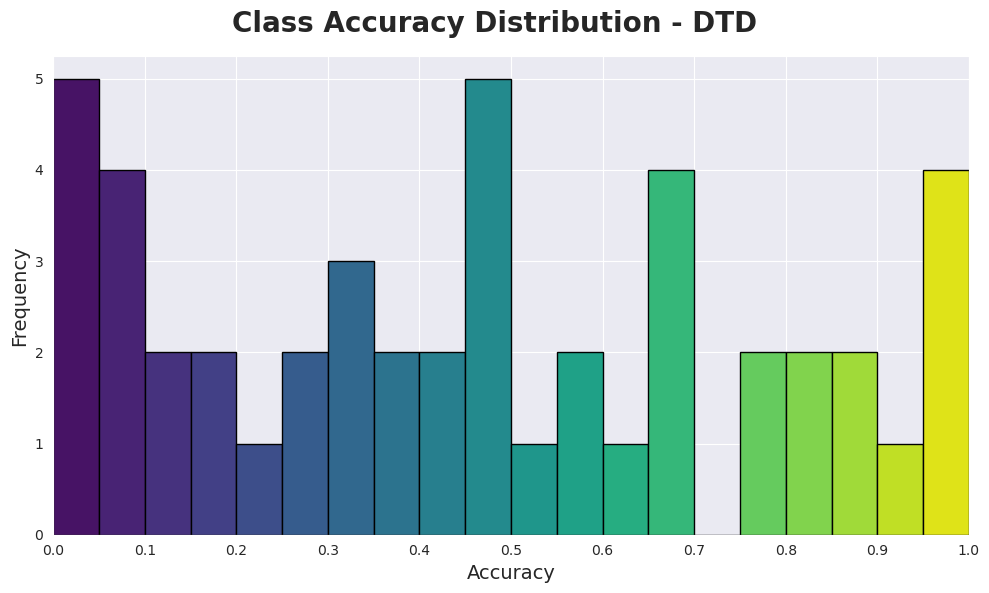

In [55]:
plot_per_class_accuracies(
    dtd_per_class_acc,
    'DTD',
    num_bins=20
)

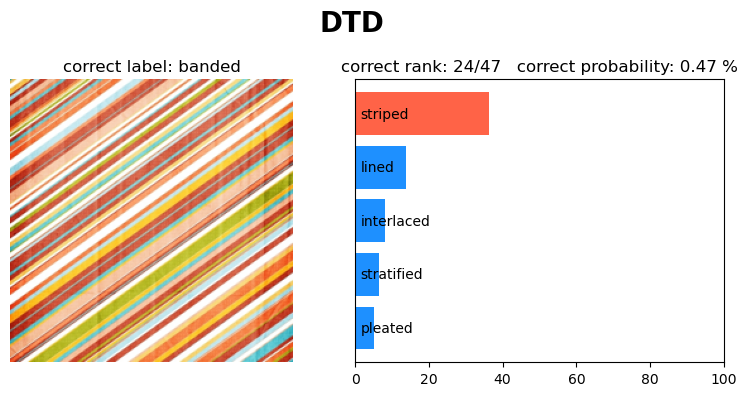

In [56]:
visualize_zero_shot_predict(
    model=model, 
    image=dtd.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=dtd.get_captions(),
    labels=dtd.get_labels(),
    label=dtd.get_label(id),
    prompt=dtd.get_prompt(),
    title='DTD',
    config=config
)

### Experiment #2 - Basic prompt

This experiment involes using a basic prompt **"a photo of {}."** as text input.

#### RESISC45

In [74]:
resisc45.set_prompt("a photo of {}.")

In [77]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = evaluate_model(
    model,
    resisc45,
    config,
    zero_shot=True
)

100%|██████████| 788/788 [01:23<00:00,  9.42it/s]

Zero-shot evaluation completed: loss: 1.5044 | acc: 0.5656


In [78]:
resisc45_accs.append(resisc45_acc)

In [80]:
get_top_5_accuracies(resisc45_per_class_acc)

[('golf course', 0.9754098360655737),
 ('sea ice', 0.9735099337748344),
 ('island', 0.9424460431654677),
 ('circular farmland', 0.910958904109589),
 ('parking lot', 0.9037037037037037)]

In [81]:
get_bottom_5_accuracies(resisc45_per_class_acc)

[('chaparral', 0.0),
 ('meadow', 0.0),
 ('terrace', 0.0),
 ('sparse residential', 0.1076923076923077),
 ('medium residential', 0.10884353741496598)]

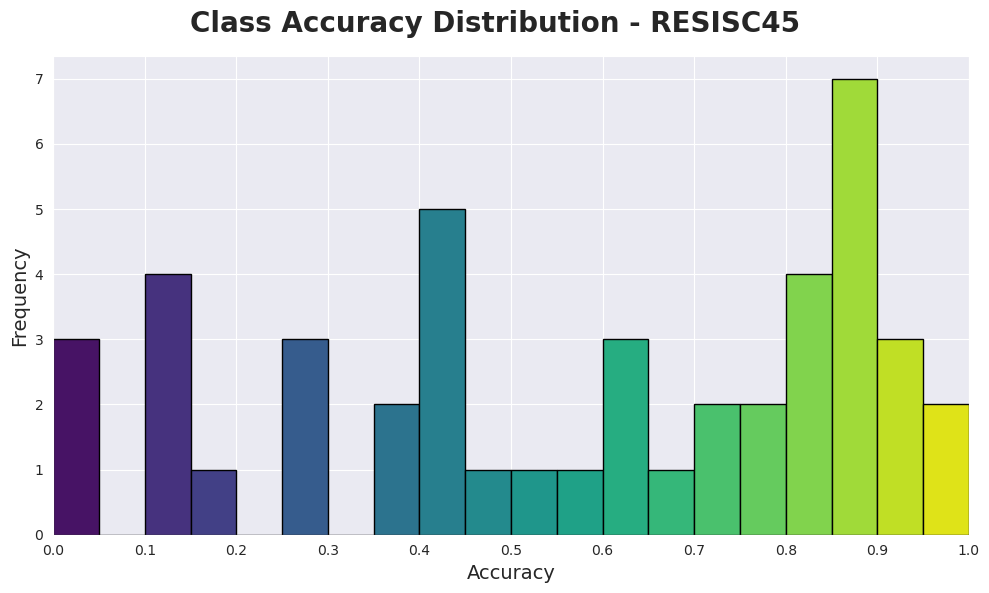

In [82]:
plot_per_class_accuracies(
    resisc45_per_class_acc,
    'RESISC45',
    num_bins=20
)

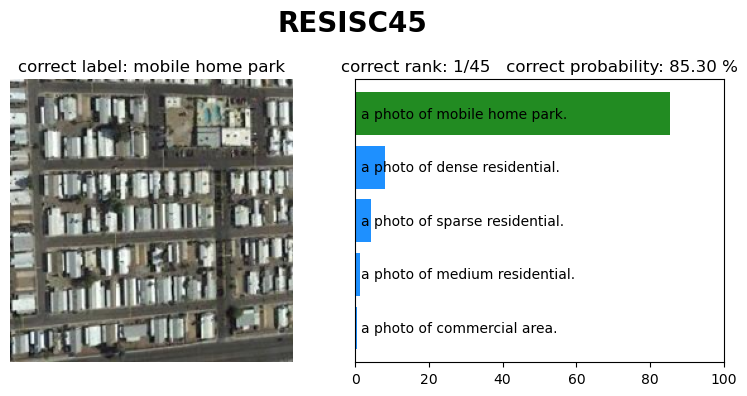

In [83]:
visualize_zero_shot_predict(
    model=model, 
    image=resisc45.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=resisc45.get_captions(),
    labels=resisc45.get_labels(),
    label=resisc45.get_label(id),
    prompt=resisc45.get_prompt(),
    title='RESISC45',
    config=config,
) 

#### Food-101

In [84]:
food101.set_prompt("a photo of {}.")

In [86]:
food101_loss, food101_acc, food101_per_class_acc = evaluate_model(
    model,
    food101,
    config,
    zero_shot=True
)

 15%|█▌        | 475/3157 [01:07<06:20,  7.04it/s]/opt/conda/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:868: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 3157/3157 [07:29<00:00,  7.02it/s]

Zero-shot evaluation completed: loss: 0.4622 | acc: 0.8656


In [87]:
food101_accs.append(food101_acc)

In [88]:
get_top_5_accuracies(food101_per_class_acc)

[('edamame', 0.996),
 ('oysters', 0.988),
 ('seaweed salad', 0.988),
 ('caesar salad', 0.984),
 ('lobster roll sandwich', 0.984)]

In [89]:
get_bottom_5_accuracies(food101_per_class_acc)

[('waffles', 0.256),
 ('ravioli', 0.292),
 ('steak', 0.396),
 ('pork chop', 0.592),
 ('ice cream', 0.628)]

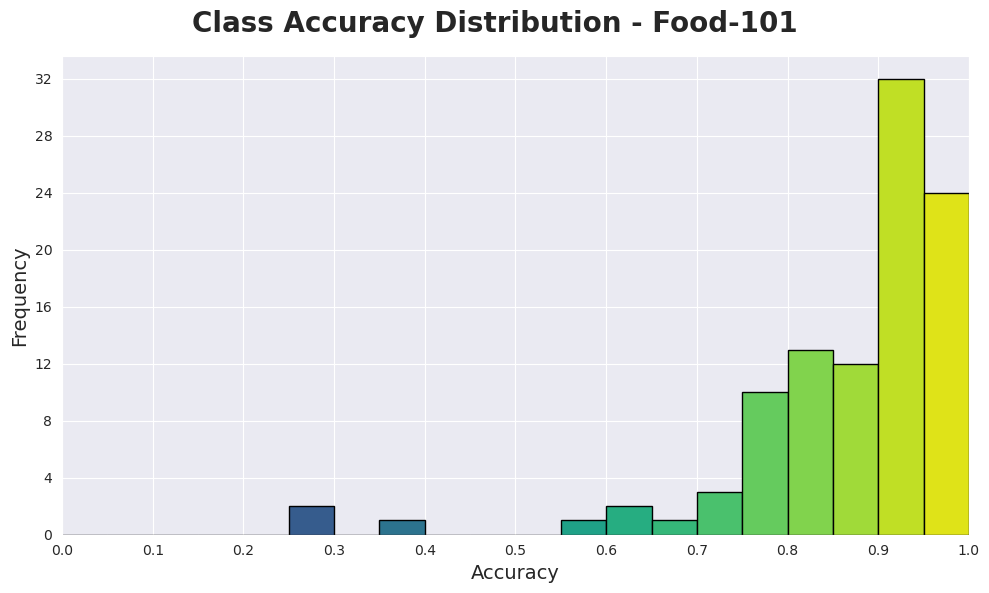

In [90]:
plot_per_class_accuracies(
    food101_per_class_acc,
    'Food-101',
    num_bins=20
)

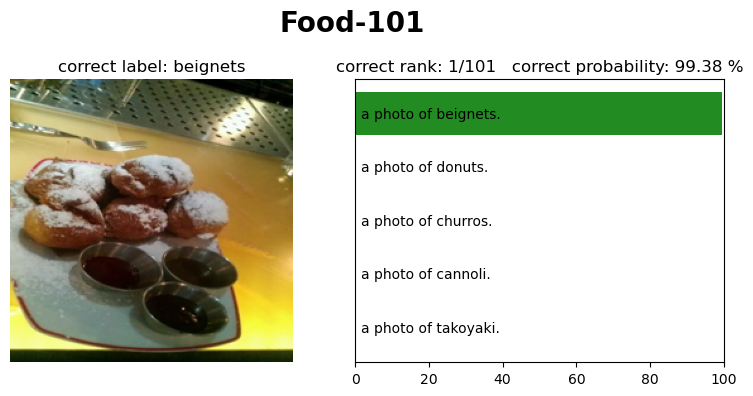

In [91]:
visualize_zero_shot_predict(
    model=model, 
    image=food101.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=food101.get_captions(),
    labels=food101.get_labels(),
    label=food101.get_label(id),
    prompt=food101.get_prompt(),
    title='Food-101',
    config=config
) 

#### FER2013

In [92]:
fer2013.set_prompt("a photo of {}.")

In [94]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = evaluate_model(
    model,
    fer2013,
    config,
    zero_shot=True
)

100%|██████████| 449/449 [00:41<00:00, 10.85it/s]

Zero-shot evaluation completed: loss: 1.5955 | acc: 0.4544


In [95]:
fer2013_accs.append(fer2013_acc)

In [96]:
fer2013_per_class_acc

{'angry': 0.8044806517311609,
 'disgust': 0.3090909090909091,
 'fear': 0.07575757575757576,
 'happy': 0.8873720136518771,
 'sad': 0.13468013468013468,
 'surprise': 0.4831730769230769,
 'neutral': 0.18849840255591055}

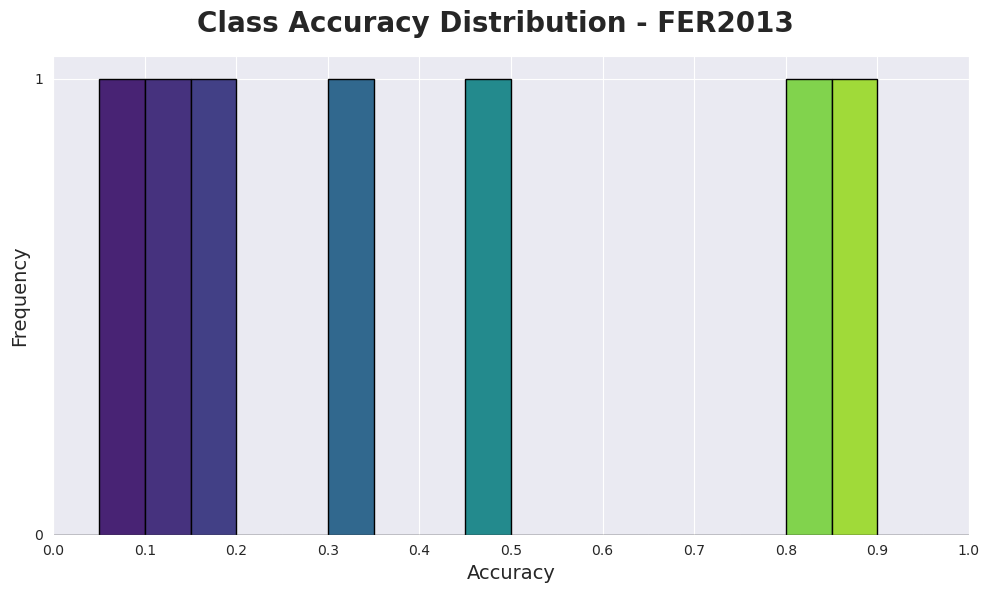

In [97]:
plot_per_class_accuracies(
    fer2013_per_class_acc,
    'FER2013',
    num_bins=20
)

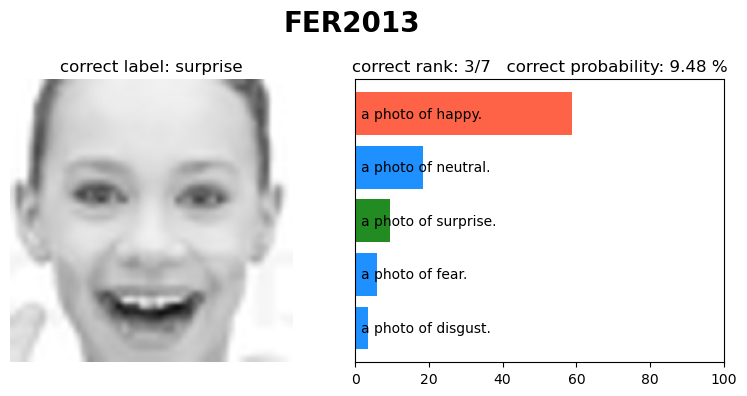

In [98]:
visualize_zero_shot_predict(
    model=model, 
    image=fer2013.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=fer2013.get_captions(),
    labels=fer2013.get_labels(),
    label=fer2013.get_label(id),
    prompt=fer2013.get_prompt(),
    title='FER2013',
    config=config
)

#### PCam

In [99]:
pcam.set_prompt("a photo of {}.")

In [100]:
pcam_loss, pcam_acc, pcam_per_class_acc = evaluate_model(
    model,
    pcam,
    config,
    zero_shot=True
)

100%|██████████| 4096/4096 [06:18<00:00, 10.81it/s]

Zero-shot evaluation completed: loss: 0.6891 | acc: 0.5537


In [101]:
pcam_accs.append(pcam_acc)

In [102]:
pcam_per_class_acc

{'healthy lymph node tissue': 0.44402415959978037,
 'lymph node tumor tissue': 0.6634304207119741}

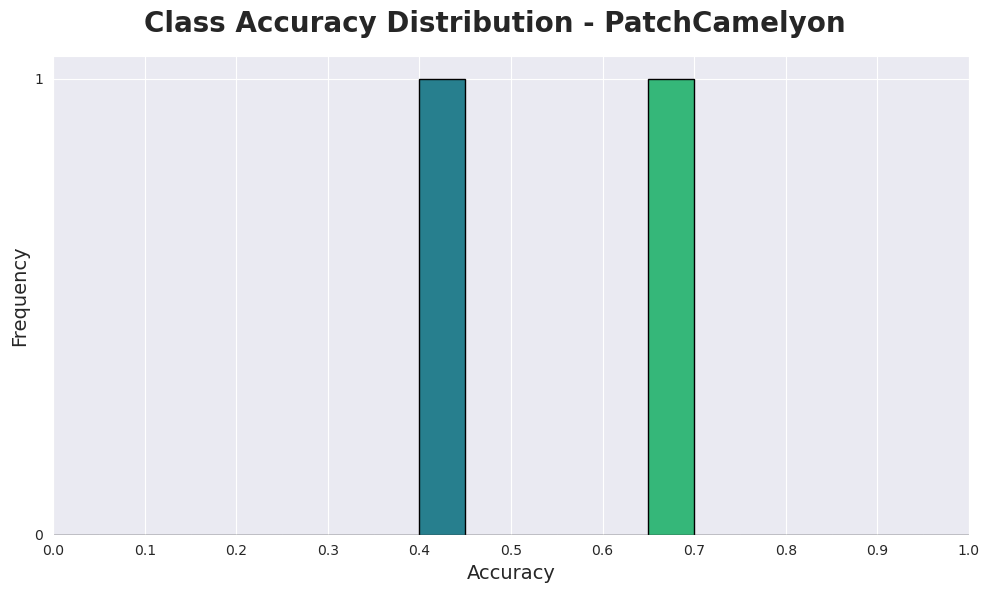

In [103]:
plot_per_class_accuracies(
    pcam_per_class_acc,
    'PatchCamelyon',
    num_bins=20
)

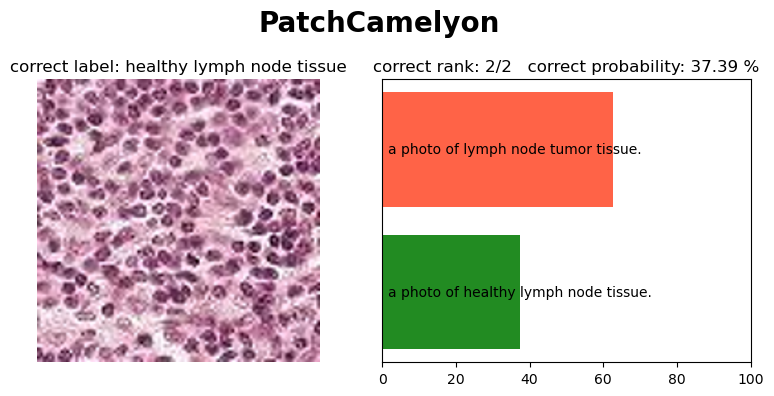

In [104]:
visualize_zero_shot_predict(
    model=model, 
    image=pcam.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=pcam.get_captions(),
    labels=pcam.get_labels(),
    label=pcam.get_label(id),
    prompt=pcam.get_prompt(),
    title='PatchCamelyon',
    config=config
)

#### SUN397

In [105]:
sun397.set_prompt("a photo of {}.")

In [107]:
sun397_loss, sun397_acc, sun397_per_class_acc = evaluate_model(
    model,
    sun397,
    config,
    zero_shot=True
)

100%|██████████| 2719/2719 [09:50<00:00,  4.61it/s]


Zero-shot evaluation completed: loss: 1.4249 | acc: 0.6222


In [108]:
sun397_accs.append(sun397_acc)

In [110]:
get_top_5_accuracies(sun397_per_class_acc)

[('aquarium', 1.0),
 ('engine room', 1.0),
 ('parking garage (indoor)', 1.0),
 ('rock arch', 1.0),
 ('skatepark', 1.0)]

In [111]:
get_bottom_5_accuracies(sun397_per_class_acc)

[('berth', 0.0),
 ('cliff', 0.0),
 ('conference center', 0.0),
 ('dinette (vehicle)', 0.0),
 ('fairway', 0.0)]

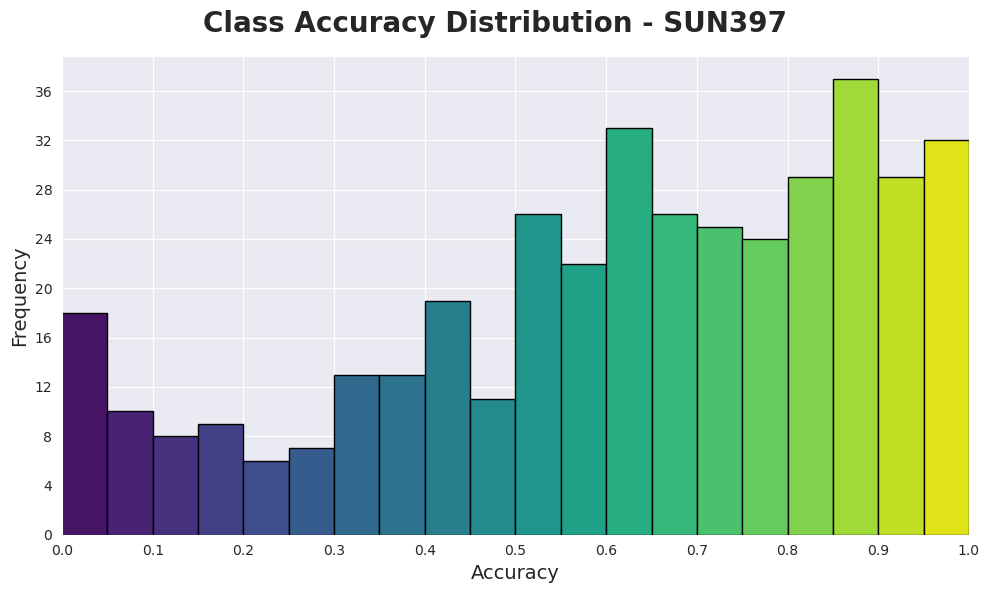

In [112]:
plot_per_class_accuracies(
    sun397_per_class_acc,
    'SUN397',
    num_bins=20
)

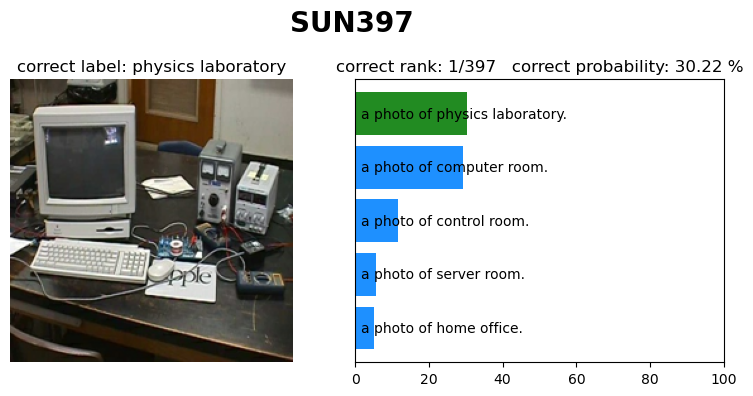

In [113]:
visualize_zero_shot_predict(
    model=model, 
    image=sun397.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=sun397.get_captions(),
    labels=sun397.get_labels(),
    label=sun397.get_label(id),
    prompt=sun397.get_prompt(),
    title='SUN397',
    config=config,
)

#### DTD

In [122]:
dtd.set_prompt("a photo of {}.")

In [124]:
dtd_loss, dtd_acc, dtd_per_class_acc = evaluate_model(
    model,
    dtd,
    config,
    zero_shot=True
)

100%|██████████| 235/235 [00:29<00:00,  7.96it/s]

Zero-shot evaluation completed: loss: 2.2582 | acc: 0.4096


In [125]:
dtd_accs.append(dtd_acc)

In [126]:
get_top_5_accuracies(dtd_per_class_acc)

[('crystalline', 1.0),
 ('chequered', 0.975),
 ('cobwebbed', 0.925),
 ('polka-dotted', 0.9),
 ('marbled', 0.875)]

In [127]:
get_bottom_5_accuracies(dtd_per_class_acc)

[('bumpy', 0.0),
 ('flecked', 0.0),
 ('interlaced', 0.0),
 ('lacelike', 0.0),
 ('pitted', 0.0)]

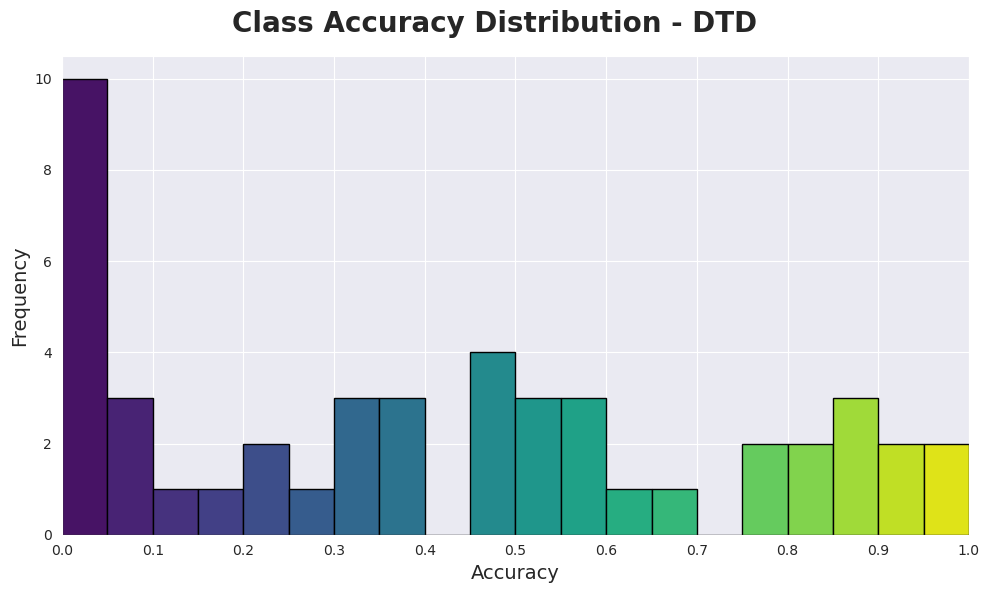

In [128]:
plot_per_class_accuracies(
    dtd_per_class_acc,
    'DTD',
    num_bins=20
)

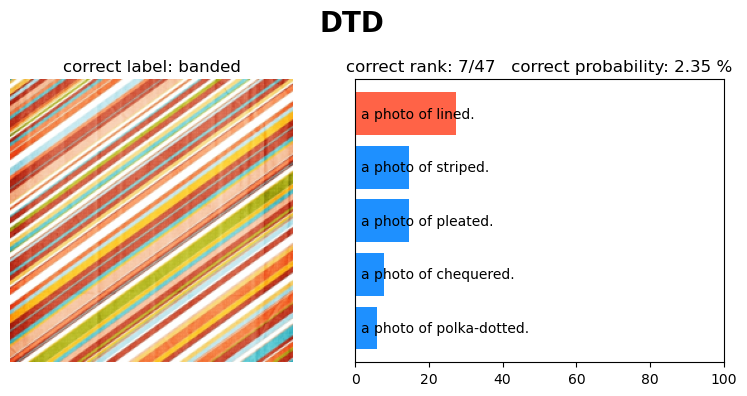

In [130]:
visualize_zero_shot_predict(
    model=model, 
    image=dtd.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=dtd.get_captions(),
    labels=dtd.get_labels(),
    label=dtd.get_label(id),
    prompt=dtd.get_prompt(),
    title='DTD',
    config=config
)

### Experiment #3 - OpenAI prompt

This experiment involes using a special, handcrafted prompt for each dataset. The prompts are taken from OpenAI's official blog on CLIP.

NOTE: Due to pre-processing, prompts may vary slighty.


https://openai.com/index/clip/

#### RESISC45

In [131]:
resisc45.set_prompt("satellite imagery of {}.")

In [133]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = evaluate_model(
    model,
    resisc45,
    config,
    zero_shot=True
)

100%|██████████| 788/788 [01:23<00:00,  9.41it/s]

Zero-shot evaluation completed: loss: 1.2502 | acc: 0.6170


In [134]:
resisc45_accs.append(resisc45_acc)

In [136]:
get_top_5_accuracies(resisc45_per_class_acc)

[('golf course', 0.9918032786885246),
 ('parking lot', 0.9777777777777777),
 ('beach', 0.9538461538461539),
 ('roundabout', 0.9328358208955224),
 ('bridge', 0.9285714285714286)]

In [137]:
get_bottom_5_accuracies(resisc45_per_class_acc)

[('chaparral', 0.007575757575757576),
 ('ground track field', 0.06299212598425197),
 ('commercial area', 0.06428571428571428),
 ('terrace', 0.07874015748031496),
 ('airplane', 0.10650887573964497)]

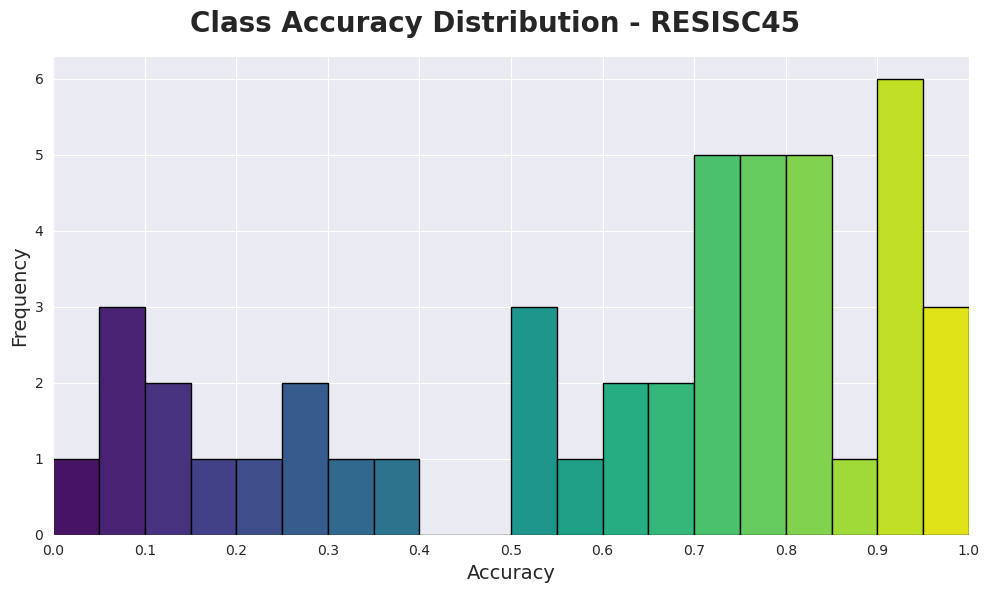

In [138]:
plot_per_class_accuracies(
    resisc45_per_class_acc,
    'RESISC45',
    num_bins=20
)

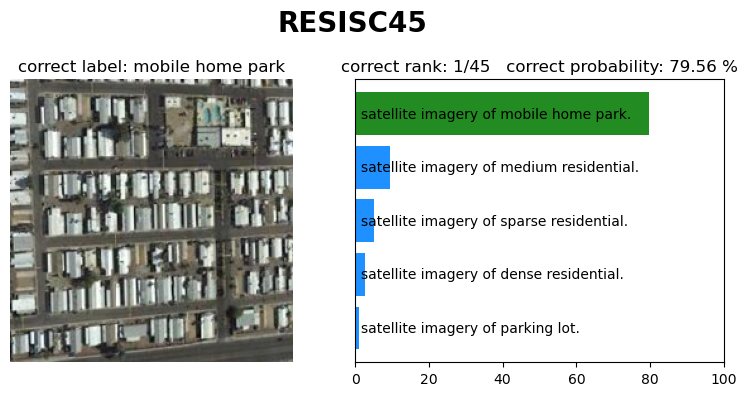

In [139]:
visualize_zero_shot_predict(
    model=model, 
    image=resisc45.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=resisc45.get_captions(),
    labels=resisc45.get_labels(),
    label=resisc45.get_label(id),
    prompt=resisc45.get_prompt(),
    title='RESISC45',
    config=config,
) 

#### Food-101

In [140]:
food101.set_prompt("a photo of {}, a type of food.")

In [142]:
food101_loss, food101_acc, food101_per_class_acc = evaluate_model(
    model,
    food101,
    config,
    zero_shot=True
)

 15%|█▌        | 475/3157 [01:11<06:39,  6.72it/s]/opt/conda/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:868: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 3157/3157 [07:53<00:00,  6.67it/s]

Zero-shot evaluation completed: loss: 0.3880 | acc: 0.8872


In [143]:
food101_accs.append(food101_acc)

In [144]:
get_top_5_accuracies(food101_per_class_acc)

[('edamame', 1.0),
 ('caesar salad', 0.988),
 ('oysters', 0.988),
 ('lobster roll sandwich', 0.984),
 ('seaweed salad', 0.984)]

In [145]:
get_bottom_5_accuracies(food101_per_class_acc)

[('steak', 0.344),
 ('ice cream', 0.644),
 ('foie gras', 0.696),
 ('cup cakes', 0.72),
 ('tacos', 0.724)]

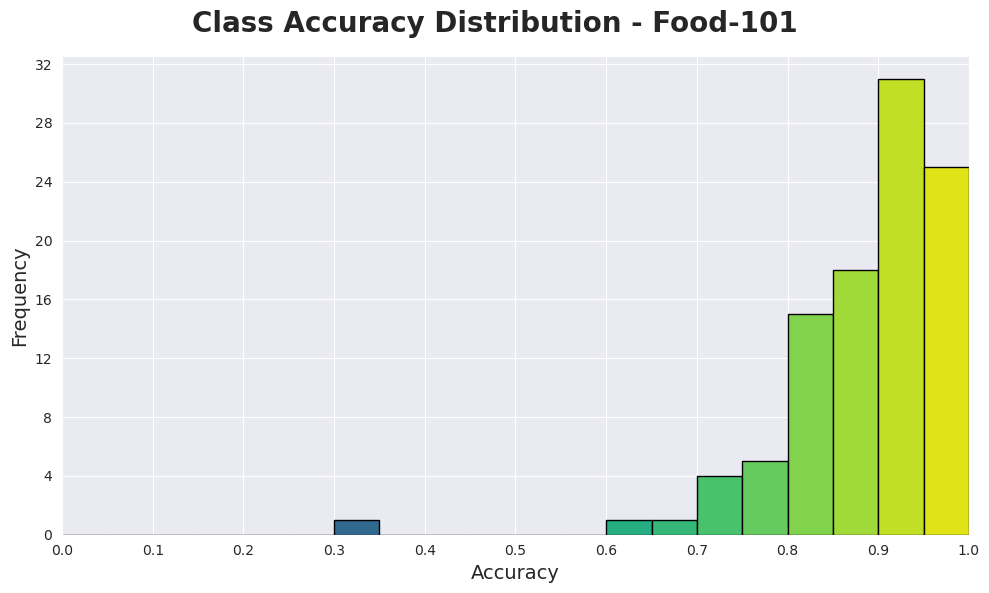

In [146]:
plot_per_class_accuracies(
    food101_per_class_acc,
    'Food-101',
    num_bins=20
)

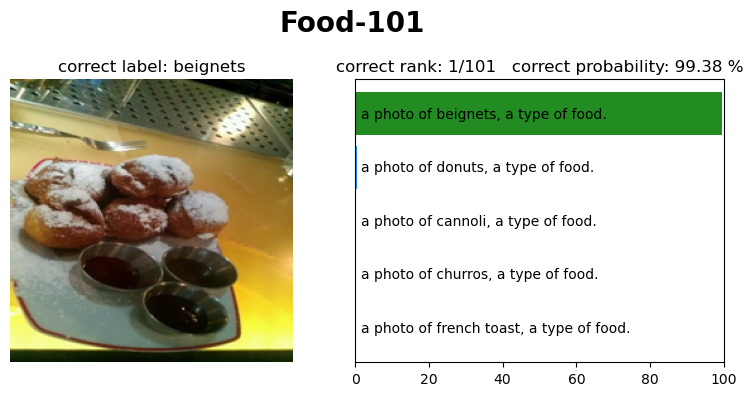

In [147]:
visualize_zero_shot_predict(
    model=model, 
    image=food101.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=food101.get_captions(),
    labels=food101.get_labels(),
    label=food101.get_label(id),
    prompt=food101.get_prompt(),
    title='Food-101',
    config=config
) 

#### FER2013

In [148]:
fer2013.set_prompt("a photo of a {} looking face.")

In [150]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = evaluate_model(
    model,
    fer2013,
    config,
    zero_shot=True
)

100%|██████████| 449/449 [00:41<00:00, 10.73it/s]

Zero-shot evaluation completed: loss: 1.4775 | acc: 0.4358


In [151]:
fer2013_accs.append(fer2013_acc)

In [153]:
fer2013_per_class_acc

{'angry': 0.5234215885947047,
 'disgust': 0.14545454545454545,
 'fear': 0.6117424242424242,
 'happy': 0.6951080773606371,
 'sad': 0.2946127946127946,
 'surprise': 0.15144230769230768,
 'neutral': 0.20287539936102236}

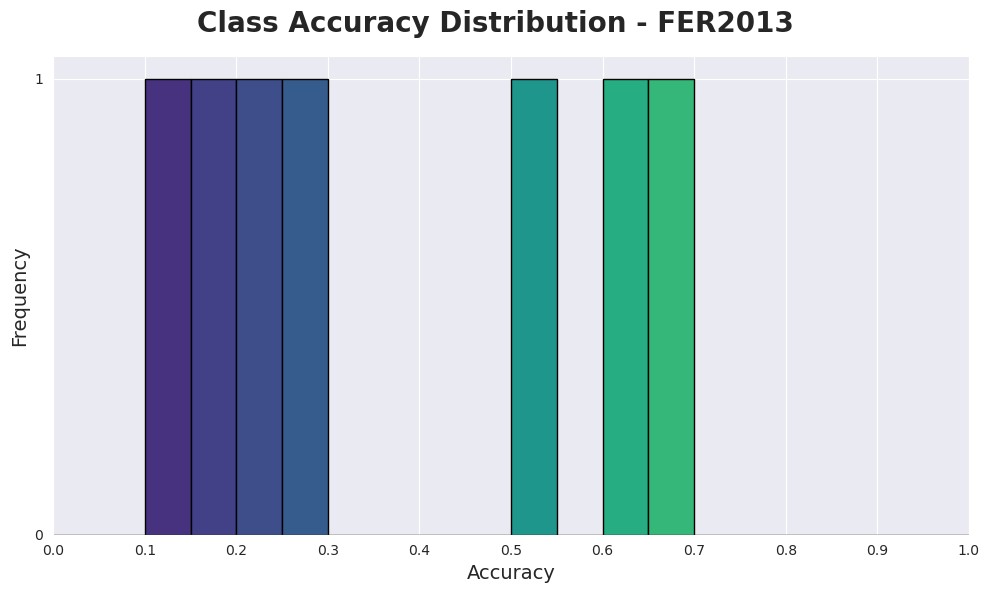

In [154]:
plot_per_class_accuracies(
    fer2013_per_class_acc,
    'FER2013',
    num_bins=20
)

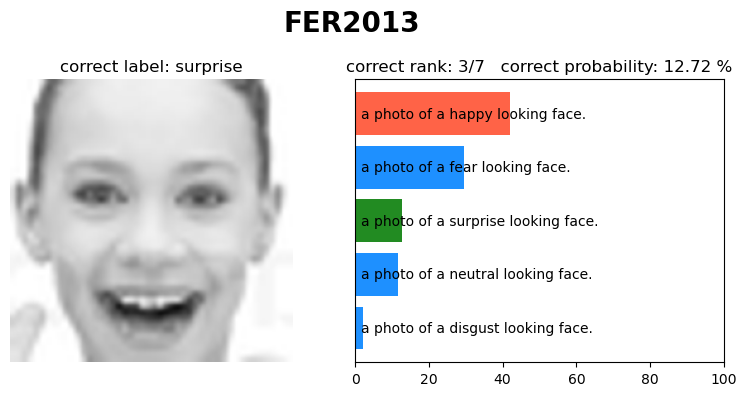

In [155]:
visualize_zero_shot_predict(
    model=model, 
    image=fer2013.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=fer2013.get_captions(),
    labels=fer2013.get_labels(),
    label=fer2013.get_label(id),
    prompt=fer2013.get_prompt(),
    title='FER2013',
    config=config
)

#### PCam

In [160]:
pcam.set_prompt("this is a photo of {}")

In [161]:
pcam_loss, pcam_acc, pcam_per_class_acc = evaluate_model(
    model,
    pcam,
    config,
    zero_shot=True
)

100%|██████████| 4096/4096 [06:19<00:00, 10.79it/s]

Zero-shot evaluation completed: loss: 0.6940 | acc: 0.5409


In [162]:
pcam_accs.append(pcam_acc)

In [163]:
pcam_per_class_acc

{'healthy lymph node tissue': 0.44847782319565616,
 'lymph node tumor tissue': 0.6333882884533186}

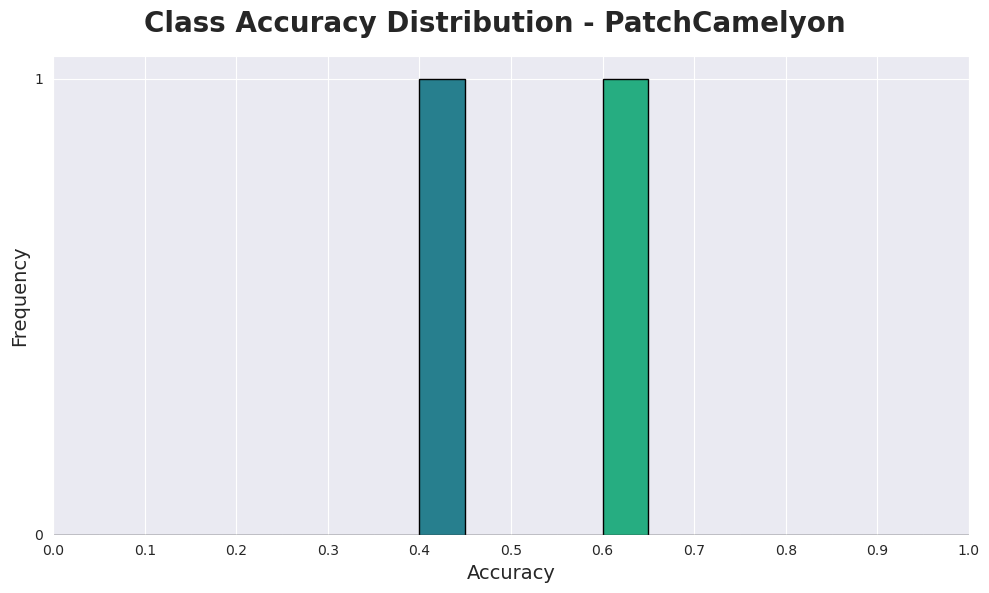

In [164]:
plot_per_class_accuracies(
    pcam_per_class_acc,
    'PatchCamelyon',
    num_bins=20
)

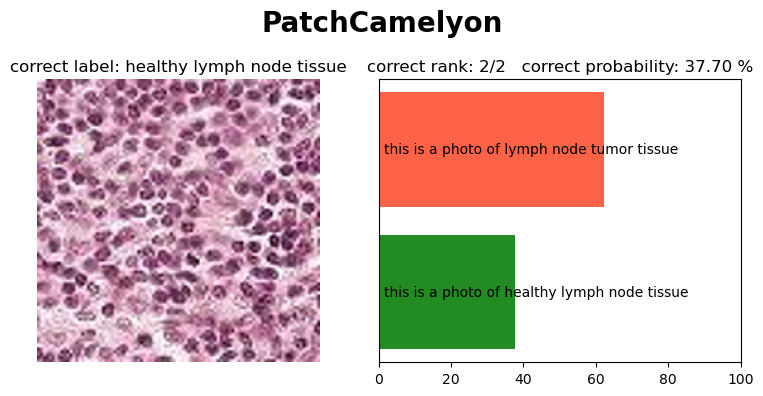

In [165]:
visualize_zero_shot_predict(
    model=model, 
    image=pcam.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=pcam.get_captions(),
    labels=pcam.get_labels(),
    label=pcam.get_label(id),
    prompt=pcam.get_prompt(),
    title='PatchCamelyon',
    config=config
)

#### SUN397

In [166]:
sun397.set_prompt("a photo of a {}.")

In [168]:
sun397_loss, sun397_acc, sun397_per_class_acc = evaluate_model(
    model,
    sun397,
    config,
    zero_shot=True
)

100%|██████████| 2719/2719 [10:09<00:00,  4.46it/s]


Zero-shot evaluation completed: loss: 1.4726 | acc: 0.5961


In [169]:
sun397_accs.append(sun397_acc)

In [171]:
get_top_5_accuracies(sun397_per_class_acc)

[('cubicle (office)', 1.0),
 ('heliport', 1.0),
 ('rock arch', 1.0),
 ('rope bridge', 1.0),
 ('skatepark', 1.0)]

In [172]:
get_bottom_5_accuracies(sun397_per_class_acc)

[('berth', 0.0),
 ('conference center', 0.0),
 ('ladning deck', 0.0),
 ('library (outdoor)', 0.0),
 ('pavilion', 0.0)]

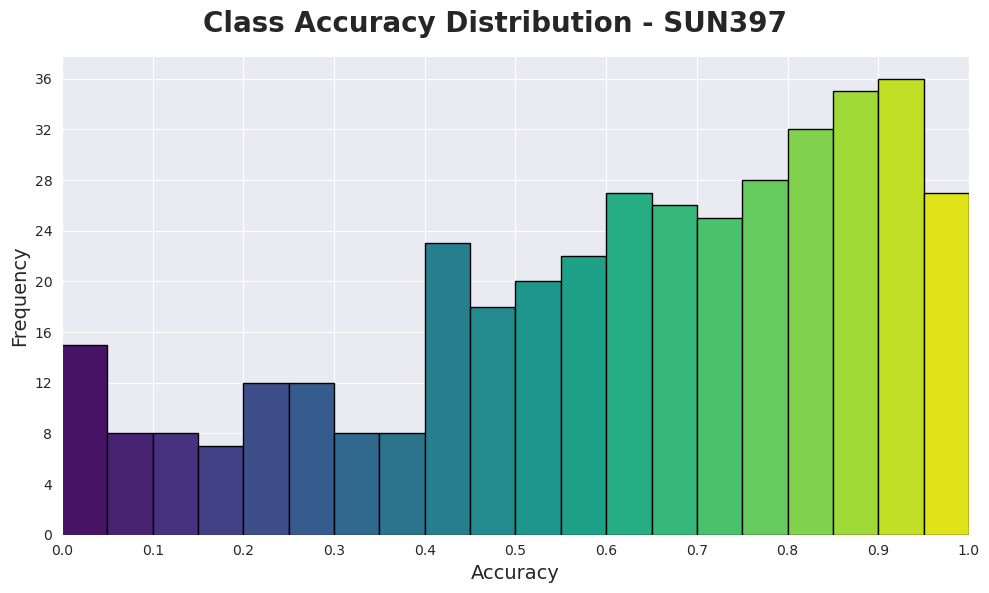

In [173]:
plot_per_class_accuracies(
    sun397_per_class_acc,
    'SUN397',
    num_bins=20
)

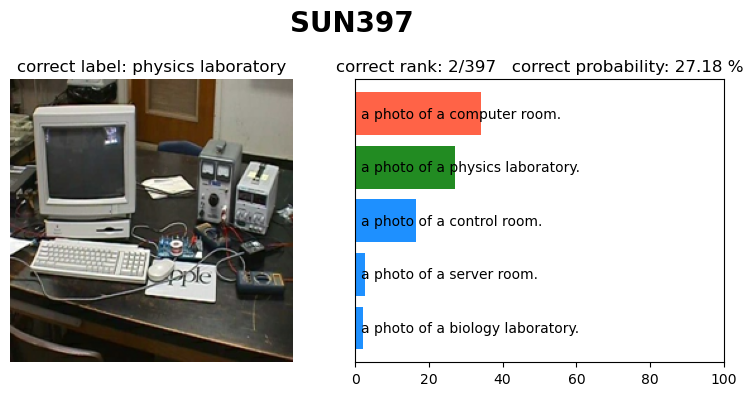

In [174]:
visualize_zero_shot_predict(
    model=model, 
    image=sun397.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=sun397.get_captions(),
    labels=sun397.get_labels(),
    label=sun397.get_label(id),
    prompt=sun397.get_prompt(),
    title='SUN397',
    config=config,
)

#### DTD

In [184]:
dtd.set_prompt("a photo of a {} texture.")

In [186]:
dtd_loss, dtd_acc, dtd_per_class_acc = evaluate_model(
    model,
    dtd,
    config,
    zero_shot=True
)

100%|██████████| 235/235 [00:30<00:00,  7.74it/s]

Zero-shot evaluation completed: loss: 2.0946 | acc: 0.4298


In [187]:
dtd_accs.append(dtd_acc)

In [188]:
get_top_5_accuracies(dtd_per_class_acc)

[('chequered', 1.0),
 ('crystalline', 0.975),
 ('knitted', 0.975),
 ('paisley', 0.975),
 ('bubbly', 0.95)]

In [189]:
get_bottom_5_accuracies(dtd_per_class_acc)

[('dotted', 0.0),
 ('flecked', 0.0),
 ('lacelike', 0.0),
 ('potholed', 0.0),
 ('grooved', 0.025)]

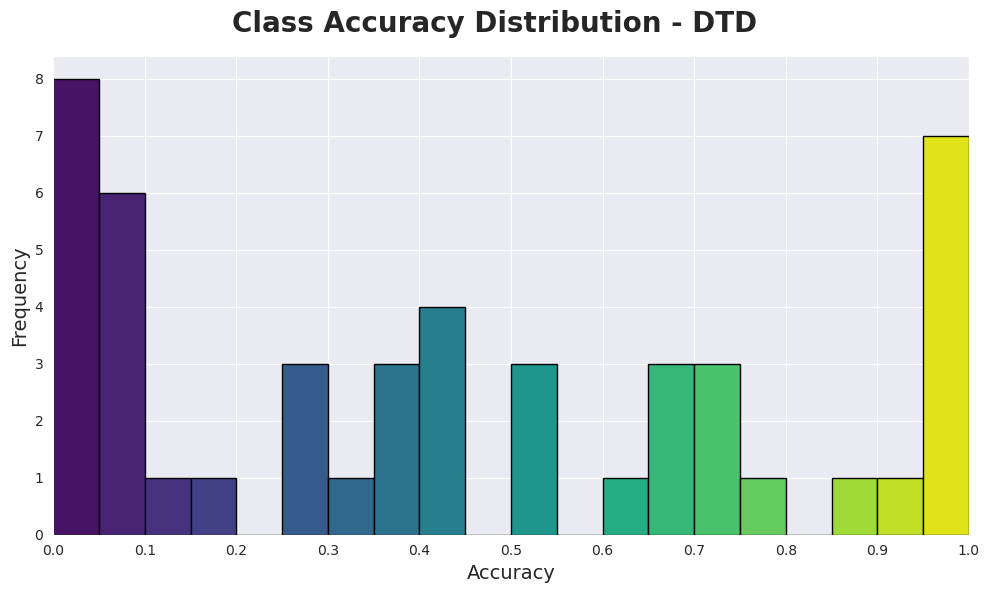

In [190]:
plot_per_class_accuracies(
    dtd_per_class_acc,
    'DTD',
    num_bins=20
)

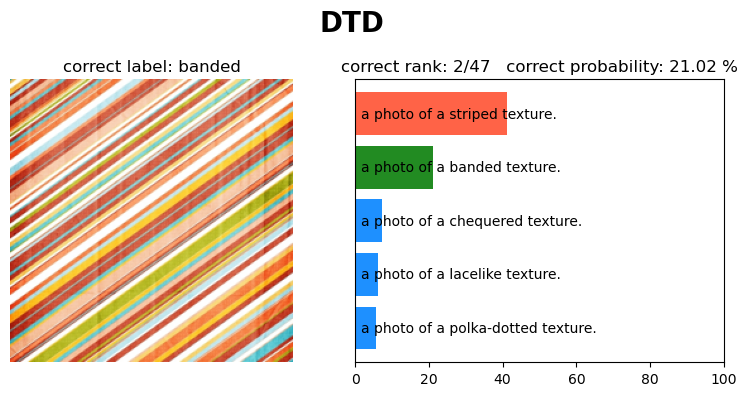

In [191]:
visualize_zero_shot_predict(
    model=model, 
    image=dtd.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=dtd.get_captions(),
    labels=dtd.get_labels(),
    label=dtd.get_label(id),
    prompt=dtd.get_prompt(),
    title='DTD',
    config=config
)

### Results

Display the results of the analysis in dataframe.

In [12]:
labels = ['RESISC45', 'Food-101', 'FER2013', 'PatchChamelyon', 'SUN397', 'DTD']
experiments = ['No prompt', 'Basic prompt', 'OpenAI prompt']
results = [
    resisc45_accs,
    food101_accs,
    fer2013_accs,
    pcam_accs,
    sun397_accs,
    dtd_accs,
]

In [13]:
acc_dict = create_accuracy_dict(
    results,
    labels
)

Create a dataframe that shows results for each dataset in each experiment.

Last two columns show the relative change between the two experiments and the base one (no prompt).

In [16]:
df = pd.DataFrame(results, columns=experiments, index=labels)
df['Basic prompt (% Δ)'] = ((df['Basic prompt'] - df['No prompt']) * 100).round(2)
df['OpenAI prompt (% Δ)'] = ((df['OpenAI prompt'] - df['No prompt']) * 100).round(2)
df

No prompt  Basic prompt  OpenAI prompt  Basic prompt (% Δ)  \
RESISC45         0.543810      0.565556       0.616984                2.17   
Food-101         0.866772      0.865584       0.887168               -0.12   
FER2013          0.408470      0.454444       0.435776                4.60   
PatchChamelyon   0.558594      0.553680       0.540894               -0.49   
SUN397           0.600000      0.622207       0.596092                2.22   
DTD              0.447340      0.409574       0.429787               -3.78   

                OpenAI prompt (% Δ)  
RESISC45                       7.32  
Food-101                       2.04  
FER2013                        2.73  
PatchChamelyon                -1.77  
SUN397                        -0.39  
DTD                           -1.76